# Import necessary libraries

In [1]:
import torch
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset
from torchsummary import summary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define training arguments

In [2]:
# Dataset directories
labeled_set_dir = 'data/cifar-10-batches-py'
unlabeled_set_dir = 'data'

# Number of epochs
num_epochs = 200

# Output csv file
output_csv_path = 'out_4.csv'

# Checkpoint path
checkpoint_path = 'model_4.pth'

# Augmentation strategy
augment = 'set2' #Choices: 'set2', None, 'set1'

#learning rate
lr = 0.1

# Model hyperparameters
blocks_in_layers = [3, 4, 4, 3]
num_layers = 4
dr= 0.0 
num_channels= [32, 64, 128, 256]
avg_pool_kernel_s=4

# Define CIFAR10 Dataset class

In [3]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data_dir, train=True, unlabeled=False, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.unlabeled = unlabeled
        # Load all data batches
        if unlabeled:
          self.data, self.id = self.load_unlabeled_data()
          self.labels = None
        else:
          self.data, self.labels = self.load_labeled_data()

    def load_cifar_batch(self, file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        return batch

    def load_labeled_data(self):
        data_batches = []
        label_batches = []
        if self.train:
          for i in range(1, 6):
            batch_file = os.path.join(self.data_dir, f'data_batch_{i}')
            batch = self.load_cifar_batch(batch_file)
            data_batches.append(batch[b'data'])
            label_batches += batch[b'labels']
        else:
          batch_file = os.path.join(self.data_dir, f'test_batch')
          batch = self.load_cifar_batch(batch_file)
          data_batches.append(batch[b'data'])
          label_batches += batch[b'labels']

        data = np.vstack(data_batches).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = np.array(label_batches)
        return data, labels

    def load_unlabeled_data(self):
        # Load the unlabeled batch
        batch_file = os.path.join(self.data_dir, 'cifar_test_nolabels.pkl')
        batch = self.load_cifar_batch(batch_file)
        data = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        id = batch[b'ids'].tolist()
        return data, id

    def __len__(self):
        if not self.unlabeled:
          return len(self.labels)
        else:
          return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.data[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        if not self.unlabeled:
          label = self.labels[idx]
          return img, label
        else:
          return img, self.id[idx]

#To seperate train and validation sets
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)



# Define Resnet class. Changed version of the Resnet class in this repo: https://github.com/kuangliu/pytorch-cifar

In [4]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out



class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_layers = 4, dropout= 0.3 ,num_channels=[64, 128, 256, 512] , avg_pool_kernel_s=4, num_classes=10):
    super(ResNet, self).__init__()
    assert len(num_channels) == num_layers
    assert len(num_blocks) == num_layers
    self.in_planes = 64
    self.avg_pool_kernel_s = avg_pool_kernel_s
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    layers = []
    for i in range(num_layers):
      stride = 1 if i == 0 else 2
      layers.append(nn.Dropout2d(p=dropout))
      layers.append( self._make_layer(block, num_channels[i], num_blocks[i], stride=stride))
    self.layers = nn.Sequential(*layers)
    self.linear = nn.Linear(num_channels[-1]*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layers(out)
    out = F.avg_pool2d(out, self.avg_pool_kernel_s)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [5]:
# If GPU available, the code uses it. Otherwise cpu is used for the training (not recommended).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load dataset




In [6]:
torch.manual_seed(42)
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10Dataset(labeled_set_dir, train=True, unlabeled=False, transform=None)
testset = CIFAR10Dataset(labeled_set_dir, train=False, unlabeled=False, transform=transform)

## Create validation set from the training set

In [7]:
total_size = len(trainset)
train_size = int(0.9 * total_size)
validation_size = total_size - train_size

# Split the dataset
generator = torch.Generator().manual_seed(42)
trainset, validationset = torch.utils.data.random_split(trainset, [train_size, validation_size], generator)
validationset = MyDataset(validationset, transform=transform)

## Augment the training dataset

In [8]:
#Augmentation
if augment is None:
    train_transform = transform
elif augment=='set1':
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
elif augment=='set2':
    train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy= transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),    
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
trainset = MyDataset(trainset, transform=train_transform)

## Create dataloader instances

In [9]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE_TRAIN,shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE_TEST,shuffle=False,  num_workers=1)
validation_loader = torch.utils.data.DataLoader(validationset,batch_size=BATCH_SIZE_TRAIN,shuffle=False,  num_workers=1)

# Define training and evaluating functions

In [10]:
def train_epoch(model, optimizer, scheduler, data_loader, loss_history, acc_history, criterion):
  total_samples = len(data_loader.dataset)
  model.train()
  correct_samples = 0
  losses = []
  for i, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    _, pred = torch.max(output, dim=1)

    losses.append(loss.item())
    correct_samples += pred.eq(target).sum()  

  avg_loss = np.mean(losses)  
  loss_history.append(avg_loss)
  acc = correct_samples / total_samples
  acc_history.append(acc.item())  
  print('\nAverage training loss: ' + '{:.4f}'.format(avg_loss) +
  ' Accuracy:' + '{:5}'.format(correct_samples) + '/' + '{:5}'.format(total_samples) + ' (' +
  '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
  scheduler.step()

In [11]:
def evaluate(model, data_loader, loss_history, acc_history, criterion, set_name='test'):
  model.eval()
  total_samples = len(data_loader.dataset)
  correct_samples = 0
  losses = []
  acc = []
  with torch.no_grad():
    for data, target in data_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
      _, pred = torch.max(output, dim=1)

      losses.append(loss.item())
      correct_samples += pred.eq(target).sum()

  avg_loss = np.mean(losses)
  loss_history.append(avg_loss)
  acc = correct_samples / total_samples
  acc_history.append(acc.item())
  print('\nAverage '+ set_name + ' loss: ' + '{:.4f}'.format(avg_loss) +
  ' Accuracy:' + '{:5}'.format(correct_samples) + '/' + '{:5}'.format(total_samples) + ' (' +
  '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

# Create model, optimizer, schedular, criterion

In [12]:
model = ResNet(BasicBlock,
               blocks_in_layers, 
               num_layers = num_layers, 
               dropout=dr,
               num_channels=num_channels, 
               avg_pool_kernel_s=avg_pool_kernel_s, 
               num_classes=10)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr,
                     momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                 T_max=num_epochs)  # eta_min is the minimum lr
criterion = nn.CrossEntropyLoss()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]          18,432
       BatchNorm2d-5           [-1, 32, 32, 32]              64
            Conv2d-6           [-1, 32, 32, 32]           9,216
       BatchNorm2d-7           [-1, 32, 32, 32]              64
            Conv2d-8           [-1, 32, 32, 32]           2,048
       BatchNorm2d-9           [-1, 32, 32, 32]              64
       BasicBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
           Conv2d-13           [-1, 32, 32, 32]           9,216
      BatchNorm2d-14           [-1, 32,

# Train

In [13]:
best_val_loss = np.inf  # Track the highest validation accuracy

start_time = time.time()
train_loss_history, valid_loss_history = [], []
train_acc_history, valid_acc_history = [], []
termination_count = 0 #If valid loss does not decrease in 5 consecutive epochs terminate the training
for epoch in range(1, num_epochs + 1):
  print('Epoch:', epoch)
  train_epoch(model, optimizer, scheduler, train_loader, train_loss_history, train_acc_history, criterion)
  evaluate(model, validation_loader, valid_loss_history, valid_acc_history, criterion, 'validation')
  if valid_loss_history[-1] < best_val_loss:
  #Save the best model in terms of validation loss.
    torch.save(model.state_dict(), checkpoint_path)
    best_val_loss = valid_loss_history[-1]
print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1

Average training loss: 2.1459 Accuracy: 9090/45000 (20.20%)


Average validation loss: 1.7590 Accuracy: 1752/ 5000 (35.04%)

Epoch: 2

Average training loss: 1.8247 Accuracy:14302/45000 (31.78%)


Average validation loss: 1.5748 Accuracy: 2089/ 5000 (41.78%)

Epoch: 3

Average training loss: 1.6366 Accuracy:18066/45000 (40.15%)


Average validation loss: 1.3512 Accuracy: 2567/ 5000 (51.34%)

Epoch: 4

Average training loss: 1.4632 Accuracy:21345/45000 (47.43%)


Average validation loss: 1.1577 Accuracy: 2964/ 5000 (59.28%)

Epoch: 5

Average training loss: 1.3034 Accuracy:23959/45000 (53.24%)


Average validation loss: 1.1134 Accuracy: 2998/ 5000 (59.96%)

Epoch: 6

Average training loss: 1.1841 Accuracy:25998/45000 (57.77%)


Average validation loss: 0.8766 Accuracy: 3409/ 5000 (68.18%)

Epoch: 7

Average training loss: 1.0732 Accuracy:27896/45000 (61.99%)


Average validation loss: 1.2565 Accuracy: 2952/ 5000 (59.04%)

Epoch: 8

Average training loss: 0.9572 Accuracy:29990/

In [14]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Dropout2d(p=0.0, inplace=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

# Results

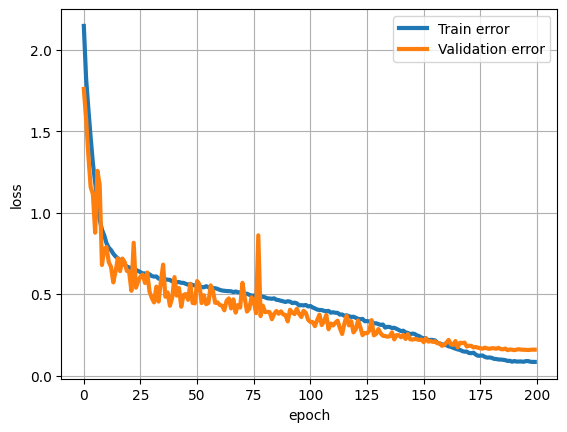

In [15]:
plt.plot(train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(valid_loss_history,'-',linewidth=3,label='Validation error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
%matplotlib inline
plt.show()

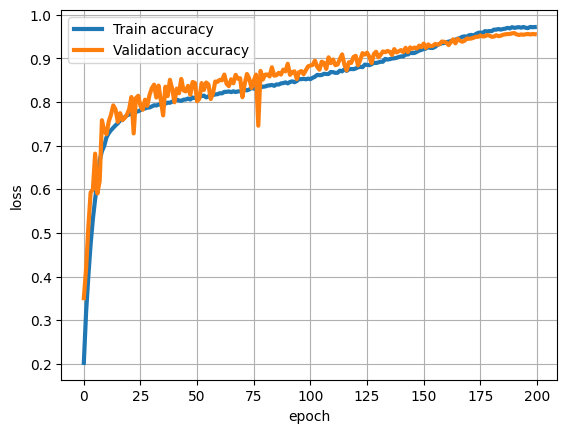

In [16]:
plt.plot(train_acc_history,'-',linewidth=3,label='Train accuracy')
plt.plot(valid_acc_history,'-',linewidth=3,label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
%matplotlib inline
plt.show()

In [17]:
evaluate(model, test_loader, [], [], criterion)


Average test loss: 0.1595 Accuracy: 9541/10000 (95.41%)



In [18]:
evaluate(model, validation_loader, [], [], criterion)


Average test loss: 0.1556 Accuracy: 4791/ 5000 (95.82%)



# Predict labels for nonlabeled dataset and save the results

In [19]:
def predict_labels(model, data_loader):
  model.eval()
  predicted_labels = []
  ids = []
  with torch.no_grad():
    for data, id in data_loader:
      data = data.to(device)
      output = model(data)
      _, pred = torch.max(output, dim=1)
      predicted_labels = predicted_labels + pred.tolist()
      ids = ids + id.tolist()
  df = pd.DataFrame({
    'ID': ids,
    'Labels': predicted_labels
})
  return df

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

unlabeled_testset = CIFAR10Dataset(unlabeled_set_dir, train=False, unlabeled=True, transform=transform)
unlabeled_test_loader = torch.utils.data.DataLoader(unlabeled_testset,batch_size=BATCH_SIZE_TEST,shuffle=False)

In [21]:
df = predict_labels(model, unlabeled_test_loader)
df.to_csv(output_csv_path, index=False)